# Aim

Get good and fast PSF fitting working, with the current models, in Python 3.8+. This could be using Theano, tf2+, or pytorch, and probably won't be using scipy.

1. (in the `oldeleanor` env) run code from master to show the baseline of fitting works
2. (in the `eleanorupgrade` env) set up frame-by-frame fitting in a new language, for sim data
3. the same as above for real data
4. set up all-at-once fitting using different weights for fluxes, and deviation-from-aperture regularization for coherence
5. the same as above for real data

In [1]:
import eleanor
import numpy as np
import lightkurve as lk
from matplotlib import pyplot as plt
import tqdm
import scipy.optimize as sopt
from scipy.special import iv
from zernike import RZern, FitZern
import torch
from torch.autograd import grad as tgrad
%load_ext autoreload
%autoreload 2

In [25]:
# first, step 1: surgically extract code from afeinstein20/eleanor/master that still operates with my new API
star = eleanor.Source(tic=120362128, sector=14, tc=True)
star.premade = False
sc = lk.search_targetpixelfile(target='tic120362128', sector=14).download()
sq = sc.quality < 5000
start = 2500
end = 3400
time = sc.time[sq][start:end].value
tpfs = sc.flux[sq][start:end].value
errs = sc.flux_err[sq][start:end].value
bkgs = sc.flux_bkg[sq,0,0][start:end].value
bkg0 = np.mean(bkgs)
data = eleanor.TargetData(
    star, 
    height=11, 
    width=11, 
    do_pca=True,
    do_psf=False,
)
sources_in_tpf = eleanor.mast.gaia_sources_in_tpf(star, 10, tpfs.shape[1:])
xc = np.array(sources_in_tpf.coords_x) + tpfs.shape[2] / 2
yc = np.array(sources_in_tpf.coords_y) + tpfs.shape[1] / 2
x, y = np.meshgrid(range(-58, 59), range(-58, 59)) 

[autoreload of eleanor.models failed: Traceback (most recent call last):
  File "/Users/adityasengupta/opt/anaconda3/envs/eleanorupgrade/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/adityasengupta/opt/anaconda3/envs/eleanorupgrade/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/adityasengupta/opt/anaconda3/envs/eleanorupgrade/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/Users/adityasengupta/opt/anaconda3/envs/eleanorupgrade/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/Users/adityasengupta/opt/anaconda3/envs/eleanorupgrade/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)


In [26]:
data.psf_lightcurve(data_arr=tpfs, err_arr=errs, bkg_arr=bkgs, model_name='Zernike', verbose=True, bkg_mag_cutoff=10, ignore_pixels=1)


100%|██████████| 900/900 [05:45<00:00,  2.61it/s]


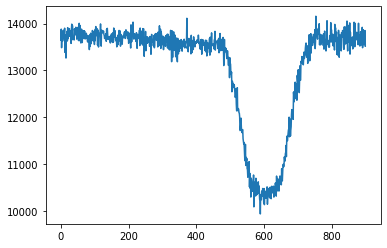

In [30]:
plt.plot(data.psf_flux[:,1])

In [31]:
data.psf_ll

array([1775649.2485267 , 1737181.33543947, 1730332.52247057,
       1761085.07251394, 1765817.11273481, 1762822.39418203,
       1763858.19512831, 1776609.10212991, 1772807.43920298,
       1723289.81119204, 1781151.44181928, 1752122.34625814,
       1719043.43356091, 1734538.79473334, 1727786.10106485,
       1670535.62918782, 1721603.81861256, 1743579.88809382,
       1762269.35110275, 1744429.67407958, 1740652.06890558,
       1723054.54509074, 1741038.32172271, 1761949.57555759,
       1701270.94448803, 1734828.03221474, 1757172.36541972,
       1739260.27304824, 1751645.74147753, 1748249.37882955,
       1776898.96288894, 1732878.15157982, 1740906.78856906,
       1753091.24969077, 1748092.765396  , 1740774.25776991,
       1723371.64663033, 1745302.30230533, 1759858.6929305 ,
       1726777.30551291, 1724588.69220296, 1761190.24459744,
       1753582.17761251, 1751059.35215231, 1749974.88451887,
       1759180.75065679, 1772427.88347996, 1731847.34466718,
       1753796.78101017,

In [32]:
lk.estimate_cdpp(data.psf_flux[:,1]).value

3388.8908950555133

In [64]:
prf = eleanor.make_prf_from_source(star)

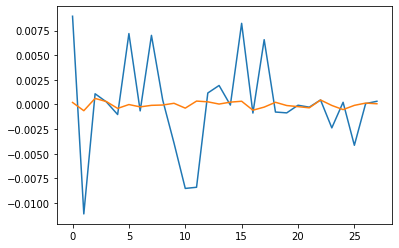

In [104]:
plt.plot(ip.fit(prf.flatten()))
plt.plot(ip.fit(prf.flatten() - twoD_Gaussian((x, y), *popt)))